# **New Zealand flood study - updates using the latest data**

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *
from wwa_nonstationary_fitting import *

# move home directory to make sure everything gets saved in the right subfolder
os.chdir("/home/clair/wwa/23-02_NZ-flood/updated")

# load shapefile of study region
sf = gpd.read_file("../sf_hawkes-gisborne")

## **MSWEP**


In [2]:
# update daily files with latest download
for y in range(2021, 2024):
    pr = xr.open_mfdataset("/home/clair/Data/mswep_nrt/"+str(y)+"*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179))
    pr.to_netcdf("../data/mswep-daily_"+str(y)+".nc")

In [3]:
# daily time series over Hawkes-Gisborne region
pr = xr.open_mfdataset("../data/mswep-daily_*.nc").precipitation
pr_hg = pr.where(regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat).squeeze(drop = True) == 1).mean(["lat", "lon"])
pr_hg.to_netcdf("mswep_daily-ts.nc")

## **Station composite**

In [4]:
comp = xr.open_dataset("HawkesBayGisborneDailyRainfall_v4.nc").precipitation_amount.rolling(time = 2).sum().resample(time = "AS-JUL", label = "right").max()
mswep = xr.open_dataset("mswep_daily-ts.nc").precipitation.rolling(time = 2).sum().resample(time = "AS-JUL", label = "right").max()

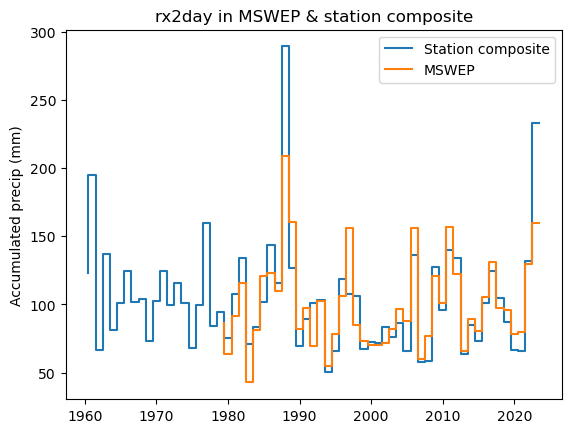

In [50]:
# quick visual comparison of 2023 precip from the two sources
plt.step(comp.time, comp, label = "Station composite")
plt.step(mswep.time, mswep, label = "MSWEP")

plt.ylabel("Accumulated precip (mm)")
plt.title("rx2day in MSWEP & station composite")
plt.legend()

plt.savefig("rx2day_timeseries.png")

### **Fitted trends**

In [6]:
comp = xr.open_dataset("HawkesBayGisborneDailyRainfall_v4.nc").precipitation_amount.rolling(time = 2).sum().resample(time = "AS-JUL", label = "right").max()
mswep = xr.open_dataset("mswep_daily-ts.nc").precipitation.rolling(time = 2).sum().resample(time = "AS-JUL", label = "right").max()

In [12]:
comp_df, mswep_df = [pd.merge(da.assign_coords(time = da.time.dt.year).rename("rx2day").to_dataframe(), 
                             pd.read_csv("../../90_data/gmst.dat", comment = "#", sep = " +", engine = "python", header = None, names = ["year","gmst"], index_col = 0),
                             left_index = True, right_index = True) for da in [comp, mswep]]

In [14]:
event_gmst = comp_df.loc[2023,"gmst"]
comp_value, mswep_value = [df.loc[2023,"rx2day"] for df in [comp_df, mswep_df]]

# fit model to each dataset

comp_mdl, mswep_mdl = [ns_fit(gev, "fixeddisp", df, "gmst", "rx2day") for df in [comp_df, mswep_df]]

In [ ]:
# # bootstrap parameters
# boot_res = boot_results(mswep_mdl, event_gmst, event_gmst-1.2, event_value = mswep_value, rp = int(return_period(mswep_mdl, mswep_value, event_gmst)), relative_deltaI = True)
# boot_res.to_csv("boot-results_mswep.csv")

# # bootstrap parameters
# boot_res = boot_results(comp_mdl, event_gmst, event_gmst-1.2, event_value = comp_value, rp = int(return_period(comp_mdl, comp_value, event_gmst)), relative_deltaI = True)
# boot_res.to_csv("boot-results_composite.csv")

# # bootstrap parameters
# scomp_mdl = ns_fit(gev, "fixeddisp", comp_df.loc[slice(1979,None)], "gmst", "rx2day")
# boot_res = boot_results(scomp_mdl, event_gmst, event_gmst-1.2, event_value = comp_value, rp = int(return_period(scomp_mdl, comp_value, event_gmst)), relative_deltaI = True)
# boot_res.to_csv("boot-results_composite_1979.csv")

In [45]:
print("dI in stations:", delta_I(comp_mdl, 50, event_gmst, event_gmst - 1.2, relative = True).round())
print("dI in MSWEP:", delta_I(mswep_mdl, 50, event_gmst, event_gmst - 1.2, relative = True).round())
print()
print("PR in stations:", prob_ratio(comp_mdl, comp_value, event_gmst, event_gmst - 1.2).round())
print("PR in MSWEP:", prob_ratio(mswep_mdl, comp_value, event_gmst, event_gmst - 1.2).round())

dI in stations: -18.0
dI in MSWEP: 32.0

PR in stations: 0.0
PR in MSWEP: 7.0


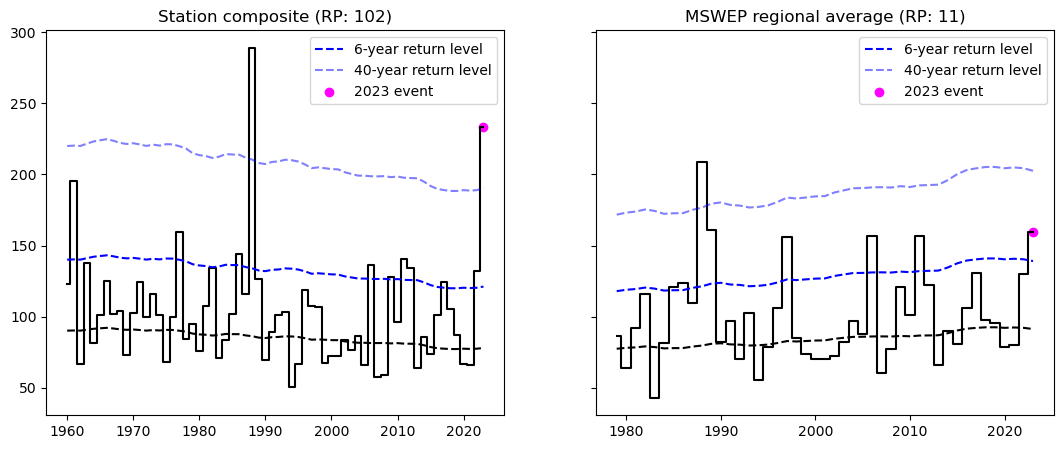

In [17]:
fig, axs = plt.subplots(ncols = 2, figsize = (13,5), dpi = 100, sharey = True)

for i in range(2):
    
    ax = axs[i]
    df = [comp_df, mswep_df][i]
    mdl = [comp_mdl, mswep_mdl][i]
    
    ax.step(df.index, df.rx2day, color = "k", where = "mid")
    ns_pars(mdl)["loc"].plot(ax = ax, color = "k", ls = "--", label = "_")
    ax.plot(df.index, return_level(mdl, 6), color = "blue", ls = "--", label = "6-year return level")
    ax.plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5, label = "40-year return level")
    ax.scatter(2023, df.loc[2023, "rx2day"], color = "magenta", label = "2023 event")
    
    ax.legend()
    
axs[0].set_title("Station composite (RP: "+str(int(return_period(comp_mdl, comp_value, event_gmst)))+")")
axs[1].set_title("MSWEP regional average (RP: "+str(int(return_period(mswep_mdl, mswep_value, event_gmst)))+")")

plt.savefig("mswep_station-composite-v4_trendplots.png")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


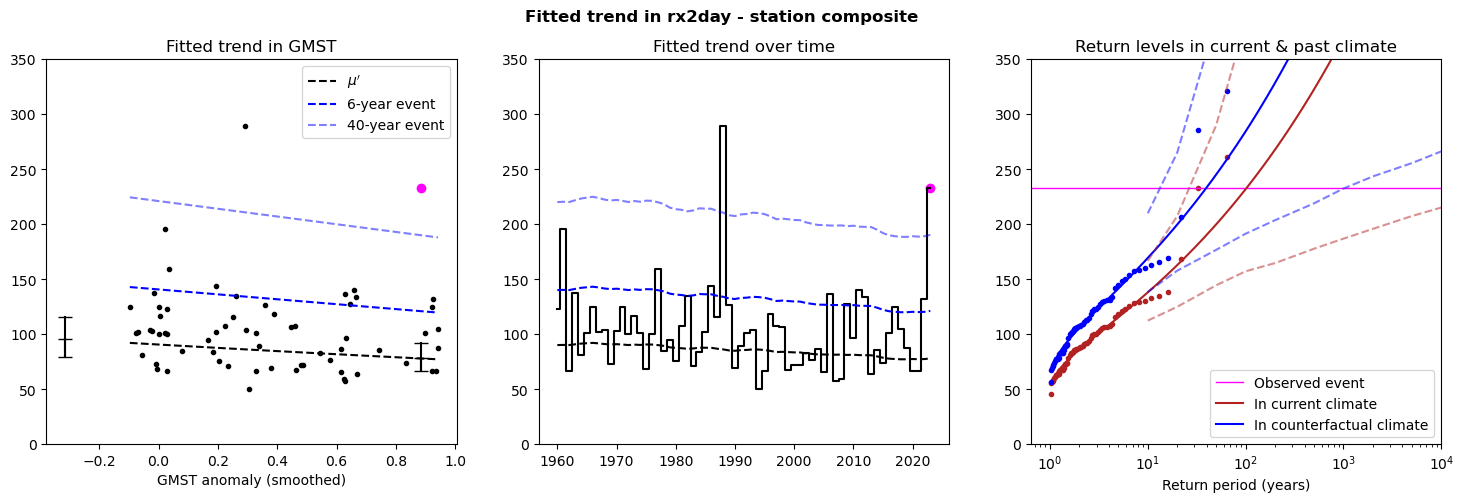

In [47]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), dpi = 100, sharey = False)

mdl = comp_mdl; event_value = comp_value; df = comp_df; boot_res = pd.read_csv("boot-results_composite.csv")

#################################################################################

axs[0].set_title("Fitted trend in GMST")
trendplot(mdl, event_gmst, event_gmst-1.2, ax = axs[0], loc1 = boot_res.loc1, loc2 = boot_res.loc2)
axs[0].legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

axs[1].step(df.index, df.rx2day, color = "k", where = "mid")
ns_pars(mdl)["loc"].plot(ax = axs[1], color = "k", ls = "--")
axs[1].plot(df.index, return_level(mdl, 6), color = "blue", ls = "--")
axs[1].plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5)
axs[1].scatter(2023, df.loc[2023, "rx2day"],color = "magenta")
axs[1].set_title("Fitted trend over time")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

rlplot(mdl, event_gmst, event_gmst-1.2, event_value, ci_nsamp = 500, ax = axs[2])
axs[2].set_title("Return levels in current & past climate")

#################################################################################

for ax in axs: ax.set_ylim(0, 350)
plt.suptitle("Fitted trend in rx2day - station composite", fontweight = "bold")

plt.savefig("station-composite-v4_rx2day_trendplots.png")


/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


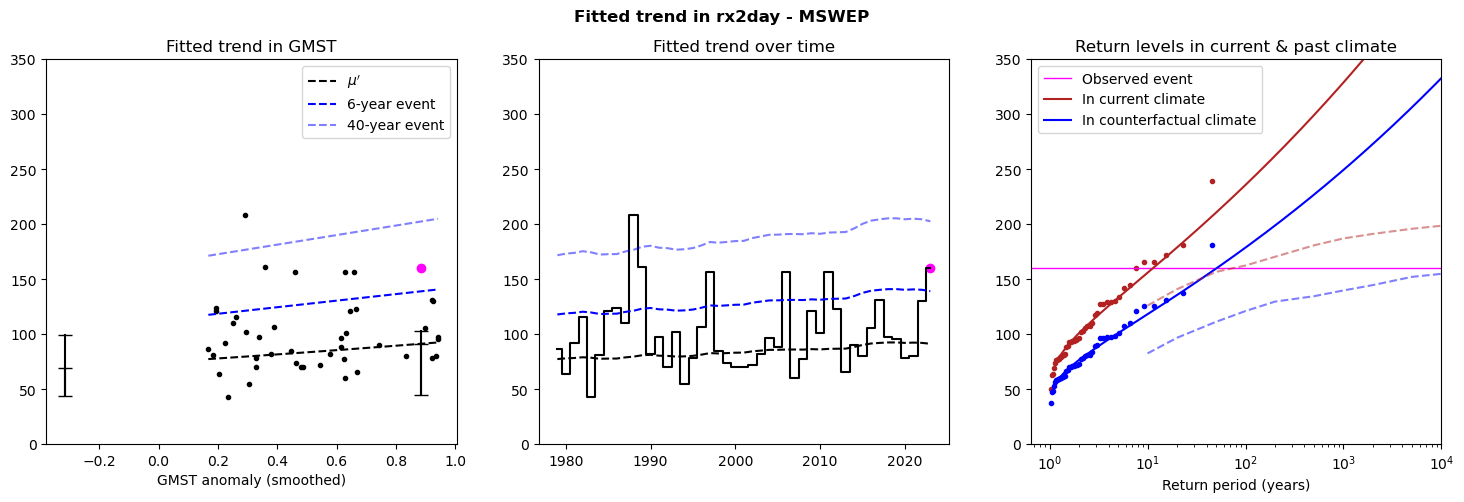

In [48]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), dpi = 100, sharey = False)

mdl = mswep_mdl; event_value = mswep_value; df = mswep_df; boot_res = pd.read_csv("boot-results_mswep.csv")

#################################################################################

axs[0].set_title("Fitted trend in GMST")
trendplot(mdl, event_gmst, event_gmst-1.2, ax = axs[0], loc1 = boot_res.loc1, loc2 = boot_res.loc2)
axs[0].legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

axs[1].step(df.index, df.rx2day, color = "k", where = "mid")
ns_pars(mdl)["loc"].plot(ax = axs[1], color = "k", ls = "--")
axs[1].plot(df.index, return_level(mdl, 6), color = "blue", ls = "--")
axs[1].plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5)
axs[1].scatter(2023, df.loc[2023, "rx2day"],color = "magenta")
axs[1].set_title("Fitted trend over time")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

rlplot(mdl, event_gmst, event_gmst-1.2, event_value, ci_nsamp = 500, ax = axs[2])
axs[2].set_title("Return levels in current & past climate")

#################################################################################

for ax in axs: ax.set_ylim(0, 350)
plt.suptitle("Fitted trend in rx2day - MSWEP", fontweight = "bold")
plt.savefig("mswep_rx2day_trendplots.png")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


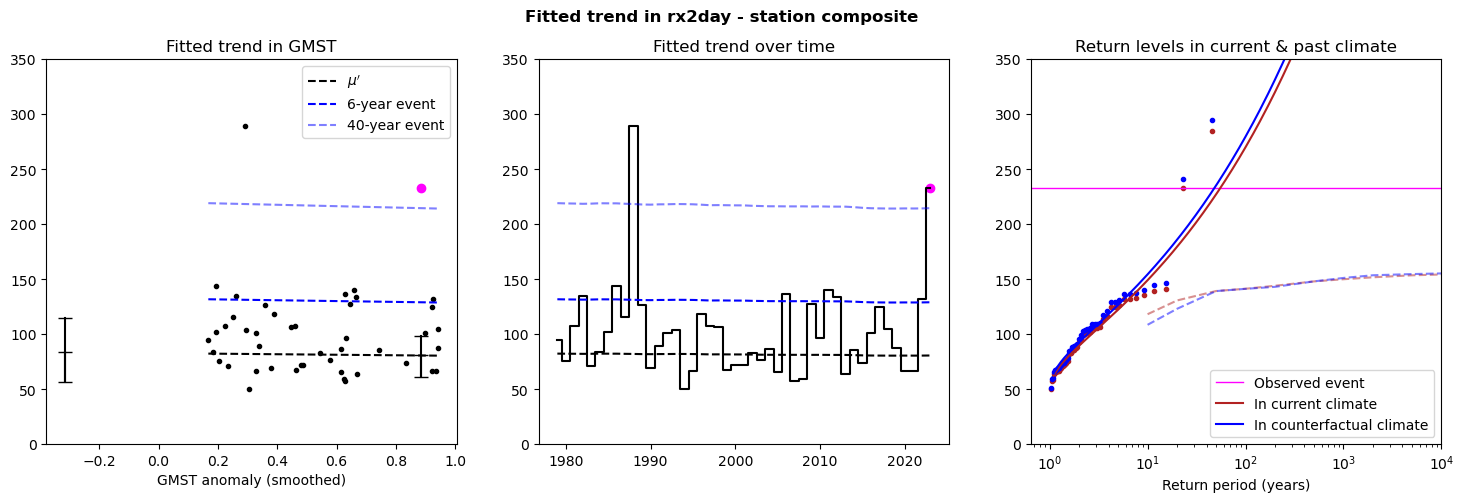

In [49]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), dpi = 100, sharey = False)

mdl = scomp_mdl; event_value = comp_value; df = comp_df.loc[slice(1979,None)]; boot_res = pd.read_csv("boot-results_composite_1979.csv")

#################################################################################

axs[0].set_title("Fitted trend in GMST")
trendplot(mdl, event_gmst, event_gmst-1.2, ax = axs[0], loc1 = boot_res.loc1, loc2 = boot_res.loc2)
axs[0].legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

axs[1].step(df.index, df.rx2day, color = "k", where = "mid")
ns_pars(mdl)["loc"].plot(ax = axs[1], color = "k", ls = "--")
axs[1].plot(df.index, return_level(mdl, 6), color = "blue", ls = "--")
axs[1].plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5)
axs[1].scatter(2023, df.loc[2023, "rx2day"],color = "magenta")
axs[1].set_title("Fitted trend over time")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

rlplot(mdl, event_gmst, event_gmst-1.2, event_value, ci_nsamp = 500, ax = axs[2])
axs[2].set_title("Return levels in current & past climate")

#################################################################################

for ax in axs: ax.set_ylim(0, 350)
plt.suptitle("Fitted trend in rx2day - station composite", fontweight = "bold")

plt.savefig("station-composite-v4_rx2day_trendplots_from-1979.png")
